# **CC6204 - Deep Learning**

## **Predicción de riesgo de diabetes en etapas tempranas**

### Alumno: Matías Seda

En esta tarea vas a desarrollar un modelo de aprendizaje que sea capaz de  determinar si una persona tiene riesgo de paceder diabetes en un futuro. Los datos han sido coleccionados a través de encuestas a pacientes en el Sylhet Diabetes Hospital en Bangladesh. Los datos han sido curados y verificados por profesionales de la salud, por lo que son confiables para crear un modelo de aprendizaje.

Primero vamos a importar los paquetes necesarios para trabajar en estos datos.

In [62]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## **Descarga de archivo de datos**
Los datos están disponibles en un archivo CSV que contiene 520 muestras de 17 atributos. Los atributos son:

*   Age: numérico
*   Género: \[Male, Female\]
*   Polyuria
*   Polydipsia
*   sudden weight loss
*   weakness
*   Polyphagia
*   Genital thrush
*   visual blurring
*   Itching
*   Irritability 
*   delayed healing 
*   partial paresis 
*   muscle stiffness
*   Alopecia
*   Obesity
*   Class: \[Positive, Negative\]

Todos los atributos descritos sin valores tienen el conjunto \[Yes, No\]. 

En la siguiente celda de código, descargamos el archivo y lo leemos con Pandas. Finalmente, visualizamos algunos datos del conjunto.



In [324]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv

--2022-09-18 03:06:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34682 (34K) [application/x-httpd-php]
Saving to: ‘diabetes_data_upload.csv.1’

diabetes_data_uploa 100%[===================>]  33,87K   219KB/s    in 0,2s    

2022-09-18 03:06:33 (219 KB/s) - ‘diabetes_data_upload.csv.1’ saved [34682/34682]



In [63]:
dataset_path = 'diabetes_data_upload.csv'

In [64]:
column_names = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss',
                'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring','Itching', 'Irritability', 'delayed healing',
                'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, header=1)

dataset = raw_dataset.copy()
dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
1,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
2,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
3,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
4,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive


# **Pre-procesamiento del conjunto de datos**
El conjunto de datos es variado. El atributo "Age" es el único atributo numérico. Todos los demás atributos son nominales. Para procesar los datos nominales en una red neuronal, es mejor convertirlos a una representación numérica. En el siguiente ejemplo transformamos el atributo "Gender" con valores nominales "Female" y "Male" a valores 1.0 y 0.0, respectivamente.

Del mismo modo, cambiamos los valores nominales de todos los atributos a valores 0.0 y 1.0.

In [65]:
gender = dataset.pop('Gender')
dataset['gender'] = (gender == 'Female')*1.0

column_class = dataset.pop('class')
dataset['class'] = (column_class=='Positive')*1.0

for column in column_names:
  if column not in ['Gender', 'class', 'Age']:
    column_class = dataset.pop(column)
    dataset[column] = (column_class=='Yes')*1.0

# Prueba mostrando parte de la data para ver si tu conversión se hizo correctamente
dataset.tail()


,Age,gender,class,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
514,39,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
515,48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
516,58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
517,32,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
518,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora normalizamos el atributo "Age" y dividimos la data en conjunto de entrenamiento y conjunto de test. Esta división es siempre necesaria para poder probar si tu modelo de aprendizaje ha aprendido a generalizar con datos que no pertenecen al conjunto de entrenamiento.

In [66]:
max_age = dataset["Age"].max()
dataset["Age"] = dataset["Age"] / max_age
dataset.tail()


#80% de datos para train y 20% de datos para test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('class')
test_labels = test_dataset.pop('class')


In [67]:
#Convertimos todo a arrays Numpy
X_train = train_dataset.to_numpy()
X_test = test_dataset.to_numpy()

Y_train = train_labels.to_numpy()
Y_test = test_labels.to_numpy()

Y_train = Y_train[:,None]
Y_test = Y_test[:,None]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(415, 16)
(415, 1)
(104, 16)
(104, 1)


# **Parte 1**
Diseña y entrena un perceptrón multicapa con la data de arriba. Intenta que tu modelo alcance el mayor accuracy de test posible (ojalá por encima del 93%). Para este primer experimento puedes usar la implementación de MLP vista en clase (basada en Numpy) ó puedes usar algún framework como Tensorflow o Pytorch si es que deseas. Hay que tener en cuenta algunas consideraciones para este primer experimento:



*   Usar gradiente descendiente estocástico con un tamaño de mini-batch de 20. 
*   Usar learning rate de 0.01.
*  Los mini-batches NO se generan de manera aleatoria.

Graficar la función de loss con respecto a las épocas.

## Respuesta


In [68]:
#Packages to use pytorch
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from functools import reduce

import time
import random

In [69]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#### Clases necesarias 

In [70]:
class MLP(nn.Module):
  # We need to define two methods at leats: constructor and forward

  #Constructor is for member definitions
  def __init__(self, layers):
    super().__init__()
    self.layers = layers

  #Forward: what happens when we feed the network with data
  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)

    return self.layers(input)

In [71]:
class Model:
    def __init__(self, optimizer, model, criteron, epoch, train_iterator, test_iterator) -> None:
        self.optimizer = optimizer
        self.model = model
        self.criterion = criteron
        self.epoch = epoch

        self.train_iterator = train_iterator
        self.test_iterator = test_iterator

        self.init_device()

    def init_device(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.model = self.model.to(self.device)
        self.criterion = self.criterion.to(self.device)

    def calculate_accuracy(self, y_pred, y):
        top_pred = y_pred.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float()/y.shape[0]
        return acc

    def train(self, random=False):
        epoch_loss = 0
        epoch_acc = 0

        #We have to set the neural network in training mode. This is because during
        #training, we need gradients and complementary data to ease the computation  
        self.model.train()

        #Training loop
            
        for (x, y) in self.train_iterator:
            x = x.to(self.device) #Data
            y = y.to(self.device) #Labels
                
            self.optimizer.zero_grad() #Clean gradients
                     
            y_pred = self.model(x) #Feed the network with data

            loss = self.criterion(y_pred, y) #Compute the loss
               
            acc = self.calculate_accuracy(y_pred, y) #Compute the accuracy
                
            loss.backward() #Compute gradients
                
            self.optimizer.step() #Apply update rules
                
            epoch_loss += loss.item()
            epoch_acc += acc.item()
                
        return epoch_loss / len(self.train_iterator), epoch_acc / len(self.train_iterator)

    def evaluate(self):
        epoch_loss = 0
        epoch_acc = 0
        
        # We put the network in testing mode
        #In this mode, Pytorch doesn't use features only reserved for 
        #training (dropout for instance)    
        self.model.eval()

        with torch.no_grad(): #disable the autograd engine (save computation and memory)
            for (x, y) in self.test_iterator:
                x = x.to(self.device)
                y = y.to(self.device)

                y_pred = self.model(x)

                loss = self.criterion(y_pred, y)

                acc = self.calculate_accuracy(y_pred, y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

        return epoch_loss / len(self.test_iterator), epoch_acc / len(self.test_iterator)


    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    def run(self, print_epoch=True):
        
        y_train = np.zeros(self.epoch)
        y_test = np.zeros(self.epoch)
        
        for epoch in range(self.epoch):
    
            start_time = time.time()
            
            #Train + validation cycles  
            train_loss, train_acc = self.train()
            test_loss, test_acc = self.evaluate()
            
            y_train[epoch] = train_loss
            y_test[epoch] = test_loss
            

            if print_epoch:
                end_time = time.time()

                epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)
                
                print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                print(f'\t Val. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')
                
        return [y_train, y_test]



#### Creación datasets train y test

In [72]:
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train.flatten()).long()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test.flatten()).long()

train_data = list(zip(X_train, Y_train))
test_data = list(zip(X_test, Y_test))




#### Creación hiperparámetros y modelo

In [73]:
def create_all(batch_size=20, learning_rate=0.01, random=False):
    INPUT_DIM = 16
    OUTPUT_DIM = 2
    
    layers = nn.Sequential(
        nn.Linear(INPUT_DIM, 8),
        nn.ReLU(),
        nn.Linear(8, 4),
        nn.ReLU(),
        nn.Linear(4, OUTPUT_DIM)
    )
    
    model = MLP(layers)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    BATCH_SIZE = batch_size
    train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
    test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)
    EPOCH = 400
    
    if random:
        simplest_model = RandomModel(optimizer, model, criterion, EPOCH, batch_size, X_train, Y_train, X_test, Y_test)
    else:
        simplest_model = Model(optimizer, model, criterion, EPOCH, train_iterator, test_iterator)
    data_list = simplest_model.run()
    return data_list


In [74]:
def plot_epoch_vs_loss(data_list, title):
    y_train = data_list[0]
    y_test = data_list[1]
    
    plt.figure(figsize=(14,10))
    plt.plot(y_train, color='b', label="Train Loss")
    plt.plot(y_test, color='r', label="Test loss")
    
    plt.ylim((0, 0.9))
    plt.xlabel("Número de época", fontsize=20)
    plt.ylabel("Valor función loss", fontsize=20)
    plt.title(title,fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

In [75]:
data_list = create_all()

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.705 | Train Acc: 61.67%
	 Val. Loss: 0.691 |  Test. Acc: 63.33%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.696 | Train Acc: 61.35%
	 Val. Loss: 0.681 |  Test. Acc: 63.33%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 61.43%
	 Val. Loss: 0.674 |  Test. Acc: 63.33%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.681 | Train Acc: 61.51%
	 Val. Loss: 0.667 |  Test. Acc: 63.33%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.676 | Train Acc: 61.43%
	 Val. Loss: 0.662 |  Test. Acc: 63.33%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.670 | Train Acc: 61.59%
	 Val. Loss: 0.657 |  Test. Acc: 63.33%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.665 | Train Acc: 61.51%
	 Val. Loss: 0.652 |  Test. Acc: 63.33%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.662 | Train Acc: 61.27%
	 Val. Loss: 0.647 |  Test. Acc: 63.33%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.657 | Train Acc: 61.27%
	 Val. Loss: 0.643 |  Test. Acc: 63.33%
Epoch: 10 | Epoch T

Epoch: 88 | Epoch Time: 0m 0s
	Train Loss: 0.224 | Train Acc: 94.76%
	 Val. Loss: 0.244 |  Test. Acc: 94.17%
Epoch: 89 | Epoch Time: 0m 0s
	Train Loss: 0.224 | Train Acc: 94.52%
	 Val. Loss: 0.242 |  Test. Acc: 94.17%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.222 | Train Acc: 94.52%
	 Val. Loss: 0.240 |  Test. Acc: 94.17%
Epoch: 91 | Epoch Time: 0m 0s
	Train Loss: 0.223 | Train Acc: 94.44%
	 Val. Loss: 0.238 |  Test. Acc: 95.00%
Epoch: 92 | Epoch Time: 0m 0s
	Train Loss: 0.220 | Train Acc: 94.21%
	 Val. Loss: 0.236 |  Test. Acc: 94.17%
Epoch: 93 | Epoch Time: 0m 0s
	Train Loss: 0.217 | Train Acc: 94.52%
	 Val. Loss: 0.236 |  Test. Acc: 94.17%
Epoch: 94 | Epoch Time: 0m 0s
	Train Loss: 0.216 | Train Acc: 94.29%
	 Val. Loss: 0.235 |  Test. Acc: 94.17%
Epoch: 95 | Epoch Time: 0m 0s
	Train Loss: 0.219 | Train Acc: 94.60%
	 Val. Loss: 0.231 |  Test. Acc: 90.00%
Epoch: 96 | Epoch Time: 0m 0s
	Train Loss: 0.213 | Train Acc: 94.21%
	 Val. Loss: 0.230 |  Test. Acc: 95.00%
Epoch: 97 | Epoch T

Epoch: 163 | Epoch Time: 0m 0s
	Train Loss: 0.159 | Train Acc: 96.35%
	 Val. Loss: 0.185 |  Test. Acc: 93.33%
Epoch: 164 | Epoch Time: 0m 0s
	Train Loss: 0.159 | Train Acc: 96.35%
	 Val. Loss: 0.184 |  Test. Acc: 89.17%
Epoch: 165 | Epoch Time: 0m 0s
	Train Loss: 0.157 | Train Acc: 95.95%
	 Val. Loss: 0.184 |  Test. Acc: 93.33%
Epoch: 166 | Epoch Time: 0m 0s
	Train Loss: 0.156 | Train Acc: 95.48%
	 Val. Loss: 0.185 |  Test. Acc: 93.33%
Epoch: 167 | Epoch Time: 0m 0s
	Train Loss: 0.157 | Train Acc: 96.19%
	 Val. Loss: 0.182 |  Test. Acc: 94.17%
Epoch: 168 | Epoch Time: 0m 0s
	Train Loss: 0.155 | Train Acc: 95.48%
	 Val. Loss: 0.185 |  Test. Acc: 93.33%
Epoch: 169 | Epoch Time: 0m 0s
	Train Loss: 0.155 | Train Acc: 96.43%
	 Val. Loss: 0.182 |  Test. Acc: 93.33%
Epoch: 170 | Epoch Time: 0m 0s
	Train Loss: 0.156 | Train Acc: 96.11%
	 Val. Loss: 0.183 |  Test. Acc: 93.33%
Epoch: 171 | Epoch Time: 0m 0s
	Train Loss: 0.154 | Train Acc: 96.43%
	 Val. Loss: 0.181 |  Test. Acc: 94.17%
Epoch: 172

Epoch: 238 | Epoch Time: 0m 0s
	Train Loss: 0.127 | Train Acc: 96.43%
	 Val. Loss: 0.153 |  Test. Acc: 93.33%
Epoch: 239 | Epoch Time: 0m 0s
	Train Loss: 0.122 | Train Acc: 96.67%
	 Val. Loss: 0.153 |  Test. Acc: 93.33%
Epoch: 240 | Epoch Time: 0m 0s
	Train Loss: 0.121 | Train Acc: 96.90%
	 Val. Loss: 0.155 |  Test. Acc: 93.33%
Epoch: 241 | Epoch Time: 0m 0s
	Train Loss: 0.122 | Train Acc: 96.67%
	 Val. Loss: 0.156 |  Test. Acc: 93.33%
Epoch: 242 | Epoch Time: 0m 0s
	Train Loss: 0.121 | Train Acc: 96.67%
	 Val. Loss: 0.154 |  Test. Acc: 93.33%
Epoch: 243 | Epoch Time: 0m 0s
	Train Loss: 0.122 | Train Acc: 96.51%
	 Val. Loss: 0.150 |  Test. Acc: 93.33%
Epoch: 244 | Epoch Time: 0m 0s
	Train Loss: 0.119 | Train Acc: 96.90%
	 Val. Loss: 0.152 |  Test. Acc: 93.33%
Epoch: 245 | Epoch Time: 0m 0s
	Train Loss: 0.121 | Train Acc: 96.83%
	 Val. Loss: 0.152 |  Test. Acc: 93.33%
Epoch: 246 | Epoch Time: 0m 0s
	Train Loss: 0.120 | Train Acc: 96.59%
	 Val. Loss: 0.150 |  Test. Acc: 93.33%
Epoch: 247

Epoch: 321 | Epoch Time: 0m 0s
	Train Loss: 0.082 | Train Acc: 97.86%
	 Val. Loss: 0.119 |  Test. Acc: 94.17%
Epoch: 322 | Epoch Time: 0m 0s
	Train Loss: 0.081 | Train Acc: 97.86%
	 Val. Loss: 0.118 |  Test. Acc: 94.17%
Epoch: 323 | Epoch Time: 0m 0s
	Train Loss: 0.081 | Train Acc: 98.10%
	 Val. Loss: 0.116 |  Test. Acc: 94.17%
Epoch: 324 | Epoch Time: 0m 0s
	Train Loss: 0.080 | Train Acc: 98.10%
	 Val. Loss: 0.117 |  Test. Acc: 94.17%
Epoch: 325 | Epoch Time: 0m 0s
	Train Loss: 0.080 | Train Acc: 98.10%
	 Val. Loss: 0.120 |  Test. Acc: 93.33%
Epoch: 326 | Epoch Time: 0m 0s
	Train Loss: 0.082 | Train Acc: 97.70%
	 Val. Loss: 0.113 |  Test. Acc: 94.17%
Epoch: 327 | Epoch Time: 0m 0s
	Train Loss: 0.079 | Train Acc: 98.10%
	 Val. Loss: 0.115 |  Test. Acc: 94.17%
Epoch: 328 | Epoch Time: 0m 0s
	Train Loss: 0.079 | Train Acc: 98.10%
	 Val. Loss: 0.117 |  Test. Acc: 94.17%
Epoch: 329 | Epoch Time: 0m 0s
	Train Loss: 0.077 | Train Acc: 98.10%
	 Val. Loss: 0.117 |  Test. Acc: 94.17%
Epoch: 330

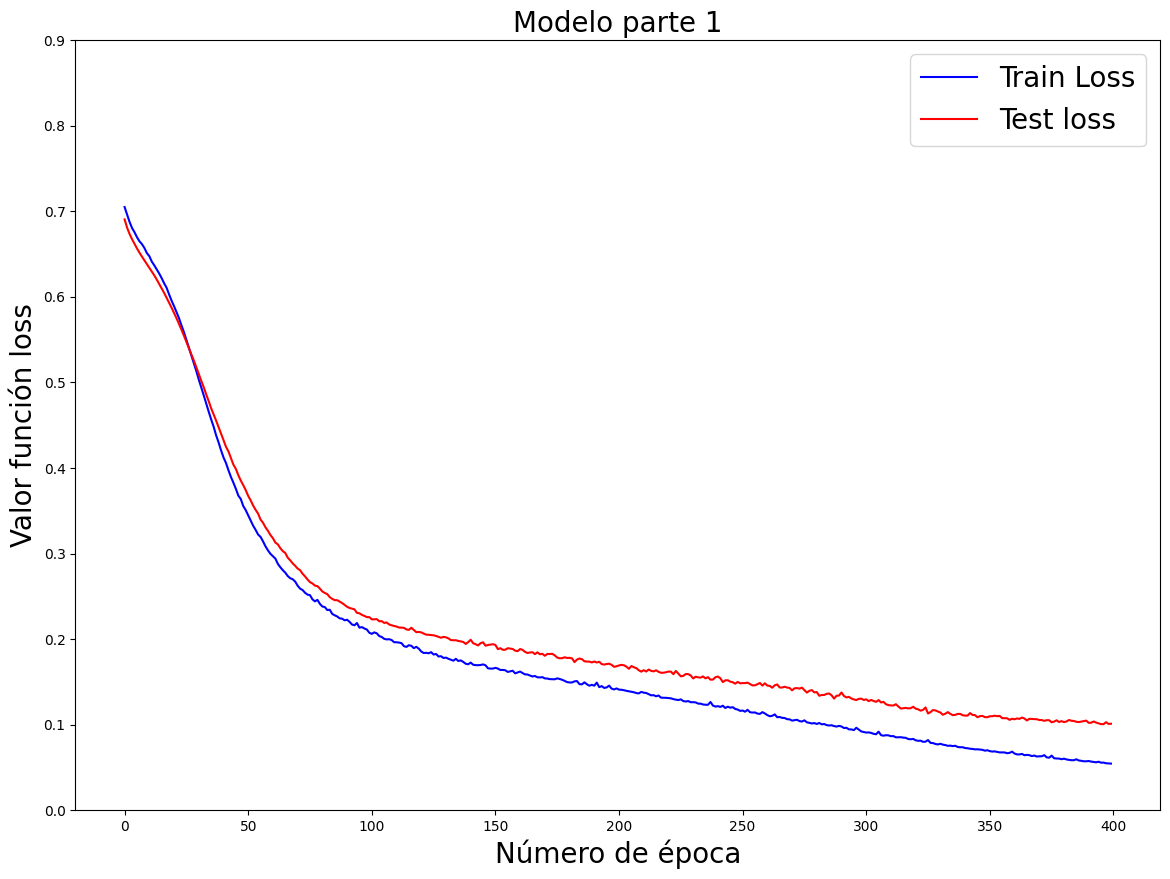

In [76]:
plot_epoch_vs_loss(data_list, "Modelo parte 1")

# **Parte 2**
Intenta cambiar el tamaño de los mini-batches. Como casos extremos usa m=1 (mini-batches de tamaño 1) y m=n(1 solo mini-batch con todos los datos). Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

#### Batch Size: m=1

In [95]:
data_list = create_all(batch_size=1)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.671 | Train Acc: 61.45%
	 Val. Loss: 0.666 |  Test. Acc: 61.54%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.667 | Train Acc: 61.45%
	 Val. Loss: 0.663 |  Test. Acc: 61.54%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.660 | Train Acc: 61.45%
	 Val. Loss: 0.641 |  Test. Acc: 61.54%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.601 | Train Acc: 61.45%
	 Val. Loss: 0.506 |  Test. Acc: 61.54%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.417 | Train Acc: 79.52%
	 Val. Loss: 0.317 |  Test. Acc: 93.27%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.289 | Train Acc: 91.08%
	 Val. Loss: 0.232 |  Test. Acc: 94.23%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.238 | Train Acc: 91.33%
	 Val. Loss: 0.242 |  Test. Acc: 92.31%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.207 | Train Acc: 94.94%
	 Val. Loss: 0.179 |  Test. Acc: 93.27%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.191 | Train Acc: 94.46%
	 Val. Loss: 0.190 |  Test. Acc: 93.27%
Epoch: 10 | Epoch T

Epoch: 77 | Epoch Time: 0m 0s
	Train Loss: 0.038 | Train Acc: 99.28%
	 Val. Loss: 0.090 |  Test. Acc: 97.12%
Epoch: 78 | Epoch Time: 0m 0s
	Train Loss: 0.039 | Train Acc: 99.04%
	 Val. Loss: 0.094 |  Test. Acc: 97.12%
Epoch: 79 | Epoch Time: 0m 0s
	Train Loss: 0.038 | Train Acc: 99.04%
	 Val. Loss: 0.100 |  Test. Acc: 97.12%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.039 | Train Acc: 99.04%
	 Val. Loss: 0.099 |  Test. Acc: 97.12%
Epoch: 81 | Epoch Time: 0m 0s
	Train Loss: 0.039 | Train Acc: 99.04%
	 Val. Loss: 0.092 |  Test. Acc: 97.12%
Epoch: 82 | Epoch Time: 0m 0s
	Train Loss: 0.038 | Train Acc: 99.04%
	 Val. Loss: 0.100 |  Test. Acc: 97.12%
Epoch: 83 | Epoch Time: 0m 0s
	Train Loss: 0.038 | Train Acc: 99.04%
	 Val. Loss: 0.105 |  Test. Acc: 97.12%
Epoch: 84 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.28%
	 Val. Loss: 0.085 |  Test. Acc: 97.12%
Epoch: 85 | Epoch Time: 0m 0s
	Train Loss: 0.039 | Train Acc: 98.80%
	 Val. Loss: 0.100 |  Test. Acc: 97.12%
Epoch: 86 | Epoch T

Epoch: 152 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.090 |  Test. Acc: 97.12%
Epoch: 153 | Epoch Time: 0m 0s
	Train Loss: 0.039 | Train Acc: 98.80%
	 Val. Loss: 0.087 |  Test. Acc: 97.12%
Epoch: 154 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.106 |  Test. Acc: 97.12%
Epoch: 155 | Epoch Time: 0m 0s
	Train Loss: 0.037 | Train Acc: 99.04%
	 Val. Loss: 0.099 |  Test. Acc: 97.12%
Epoch: 156 | Epoch Time: 0m 0s
	Train Loss: 0.037 | Train Acc: 99.04%
	 Val. Loss: 0.101 |  Test. Acc: 97.12%
Epoch: 157 | Epoch Time: 0m 0s
	Train Loss: 0.037 | Train Acc: 99.04%
	 Val. Loss: 0.096 |  Test. Acc: 97.12%
Epoch: 158 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.108 |  Test. Acc: 97.12%
Epoch: 159 | Epoch Time: 0m 0s
	Train Loss: 0.038 | Train Acc: 99.04%
	 Val. Loss: 0.096 |  Test. Acc: 97.12%
Epoch: 160 | Epoch Time: 0m 0s
	Train Loss: 0.037 | Train Acc: 99.04%
	 Val. Loss: 0.103 |  Test. Acc: 97.12%
Epoch: 161

Epoch: 227 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.097 |  Test. Acc: 97.12%
Epoch: 228 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.28%
	 Val. Loss: 0.088 |  Test. Acc: 97.12%
Epoch: 229 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.099 |  Test. Acc: 97.12%
Epoch: 230 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.088 |  Test. Acc: 97.12%
Epoch: 231 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.087 |  Test. Acc: 97.12%
Epoch: 232 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.088 |  Test. Acc: 97.12%
Epoch: 233 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.094 |  Test. Acc: 97.12%
Epoch: 234 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.103 |  Test. Acc: 97.12%
Epoch: 235 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.091 |  Test. Acc: 97.12%
Epoch: 236

Epoch: 302 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.088 |  Test. Acc: 97.12%
Epoch: 303 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.097 |  Test. Acc: 97.12%
Epoch: 304 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.100 |  Test. Acc: 97.12%
Epoch: 305 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.28%
	 Val. Loss: 0.094 |  Test. Acc: 97.12%
Epoch: 306 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.097 |  Test. Acc: 97.12%
Epoch: 307 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.087 |  Test. Acc: 97.12%
Epoch: 308 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.096 |  Test. Acc: 97.12%
Epoch: 309 | Epoch Time: 0m 0s
	Train Loss: 0.034 | Train Acc: 99.28%
	 Val. Loss: 0.083 |  Test. Acc: 96.15%
Epoch: 310 | Epoch Time: 0m 0s
	Train Loss: 0.033 | Train Acc: 99.04%
	 Val. Loss: 0.099 |  Test. Acc: 97.12%
Epoch: 311

Epoch: 377 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.097 |  Test. Acc: 97.12%
Epoch: 378 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.097 |  Test. Acc: 97.12%
Epoch: 379 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.093 |  Test. Acc: 97.12%
Epoch: 380 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.093 |  Test. Acc: 97.12%
Epoch: 381 | Epoch Time: 0m 0s
	Train Loss: 0.034 | Train Acc: 99.28%
	 Val. Loss: 0.083 |  Test. Acc: 96.15%
Epoch: 382 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.095 |  Test. Acc: 97.12%
Epoch: 383 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.098 |  Test. Acc: 97.12%
Epoch: 384 | Epoch Time: 0m 0s
	Train Loss: 0.034 | Train Acc: 99.28%
	 Val. Loss: 0.084 |  Test. Acc: 96.15%
Epoch: 385 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.092 |  Test. Acc: 97.12%
Epoch: 386

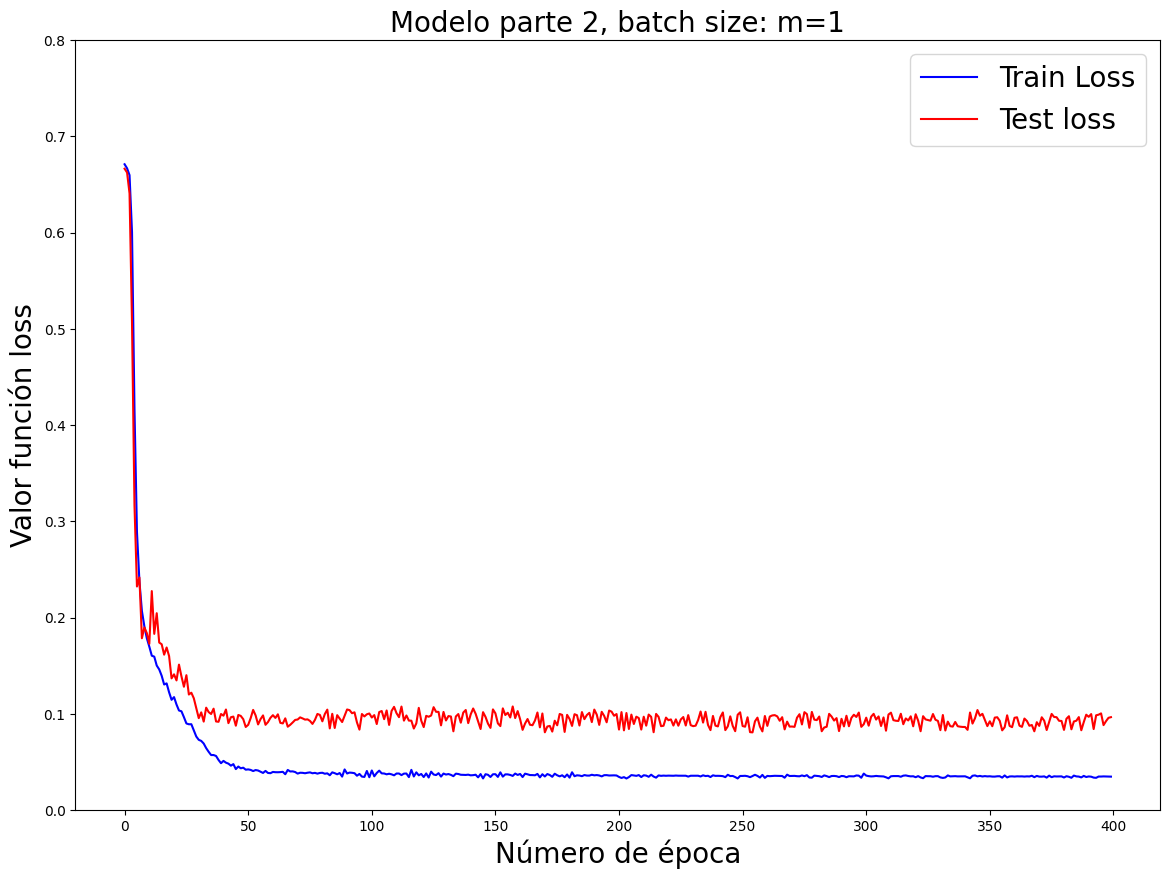

In [96]:
plot_epoch_vs_loss(data_list, "Modelo parte 2, batch size: m=1")

In [98]:
data_list = create_all(batch_size=50)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.673 | Train Acc: 61.85%
	 Val. Loss: 0.663 |  Test. Acc: 65.67%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.671 | Train Acc: 61.85%
	 Val. Loss: 0.661 |  Test. Acc: 65.67%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.670 | Train Acc: 61.85%
	 Val. Loss: 0.659 |  Test. Acc: 65.67%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.670 | Train Acc: 61.33%
	 Val. Loss: 0.657 |  Test. Acc: 65.67%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 62.37%
	 Val. Loss: 0.655 |  Test. Acc: 65.67%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.663 | Train Acc: 62.89%
	 Val. Loss: 0.653 |  Test. Acc: 65.67%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 61.33%
	 Val. Loss: 0.651 |  Test. Acc: 65.67%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.661 | Train Acc: 62.89%
	 Val. Loss: 0.649 |  Test. Acc: 65.67%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.660 | Train Acc: 62.37%
	 Val. Loss: 0.648 |  Test. Acc: 65.67%
Epoch: 10 | Epoch T

Epoch: 99 | Epoch Time: 0m 0s
	Train Loss: 0.348 | Train Acc: 88.37%
	 Val. Loss: 0.359 |  Test. Acc: 87.67%
Epoch: 100 | Epoch Time: 0m 0s
	Train Loss: 0.347 | Train Acc: 87.56%
	 Val. Loss: 0.356 |  Test. Acc: 87.67%
Epoch: 101 | Epoch Time: 0m 0s
	Train Loss: 0.346 | Train Acc: 88.07%
	 Val. Loss: 0.353 |  Test. Acc: 87.67%
Epoch: 102 | Epoch Time: 0m 0s
	Train Loss: 0.343 | Train Acc: 87.04%
	 Val. Loss: 0.351 |  Test. Acc: 87.67%
Epoch: 103 | Epoch Time: 0m 0s
	Train Loss: 0.342 | Train Acc: 87.04%
	 Val. Loss: 0.349 |  Test. Acc: 87.67%
Epoch: 104 | Epoch Time: 0m 0s
	Train Loss: 0.331 | Train Acc: 88.30%
	 Val. Loss: 0.346 |  Test. Acc: 87.67%
Epoch: 105 | Epoch Time: 0m 0s
	Train Loss: 0.321 | Train Acc: 88.81%
	 Val. Loss: 0.343 |  Test. Acc: 87.67%
Epoch: 106 | Epoch Time: 0m 0s
	Train Loss: 0.326 | Train Acc: 88.00%
	 Val. Loss: 0.340 |  Test. Acc: 87.67%
Epoch: 107 | Epoch Time: 0m 0s
	Train Loss: 0.324 | Train Acc: 88.44%
	 Val. Loss: 0.338 |  Test. Acc: 87.67%
Epoch: 108 

Epoch: 194 | Epoch Time: 0m 0s
	Train Loss: 0.185 | Train Acc: 93.93%
	 Val. Loss: 0.230 |  Test. Acc: 86.33%
Epoch: 195 | Epoch Time: 0m 0s
	Train Loss: 0.199 | Train Acc: 91.85%
	 Val. Loss: 0.228 |  Test. Acc: 86.33%
Epoch: 196 | Epoch Time: 0m 0s
	Train Loss: 0.187 | Train Acc: 94.44%
	 Val. Loss: 0.229 |  Test. Acc: 86.33%
Epoch: 197 | Epoch Time: 0m 0s
	Train Loss: 0.182 | Train Acc: 94.44%
	 Val. Loss: 0.228 |  Test. Acc: 86.33%
Epoch: 198 | Epoch Time: 0m 0s
	Train Loss: 0.192 | Train Acc: 92.89%
	 Val. Loss: 0.227 |  Test. Acc: 86.33%
Epoch: 199 | Epoch Time: 0m 0s
	Train Loss: 0.193 | Train Acc: 93.41%
	 Val. Loss: 0.227 |  Test. Acc: 86.33%
Epoch: 200 | Epoch Time: 0m 0s
	Train Loss: 0.190 | Train Acc: 93.93%
	 Val. Loss: 0.226 |  Test. Acc: 86.33%
Epoch: 201 | Epoch Time: 0m 0s
	Train Loss: 0.194 | Train Acc: 93.93%
	 Val. Loss: 0.226 |  Test. Acc: 86.33%
Epoch: 202 | Epoch Time: 0m 0s
	Train Loss: 0.188 | Train Acc: 93.93%
	 Val. Loss: 0.225 |  Test. Acc: 86.33%
Epoch: 203

Epoch: 291 | Epoch Time: 0m 0s
	Train Loss: 0.159 | Train Acc: 94.74%
	 Val. Loss: 0.183 |  Test. Acc: 95.33%
Epoch: 292 | Epoch Time: 0m 0s
	Train Loss: 0.141 | Train Acc: 95.33%
	 Val. Loss: 0.182 |  Test. Acc: 95.33%
Epoch: 293 | Epoch Time: 0m 0s
	Train Loss: 0.149 | Train Acc: 95.26%
	 Val. Loss: 0.182 |  Test. Acc: 95.33%
Epoch: 294 | Epoch Time: 0m 0s
	Train Loss: 0.141 | Train Acc: 95.56%
	 Val. Loss: 0.181 |  Test. Acc: 95.33%
Epoch: 295 | Epoch Time: 0m 0s
	Train Loss: 0.147 | Train Acc: 95.78%
	 Val. Loss: 0.182 |  Test. Acc: 95.33%
Epoch: 296 | Epoch Time: 0m 0s
	Train Loss: 0.143 | Train Acc: 95.78%
	 Val. Loss: 0.181 |  Test. Acc: 95.33%
Epoch: 297 | Epoch Time: 0m 0s
	Train Loss: 0.144 | Train Acc: 95.26%
	 Val. Loss: 0.180 |  Test. Acc: 95.33%
Epoch: 298 | Epoch Time: 0m 0s
	Train Loss: 0.153 | Train Acc: 94.74%
	 Val. Loss: 0.180 |  Test. Acc: 95.33%
Epoch: 299 | Epoch Time: 0m 0s
	Train Loss: 0.148 | Train Acc: 95.26%
	 Val. Loss: 0.180 |  Test. Acc: 95.33%
Epoch: 300

Epoch: 381 | Epoch Time: 0m 0s
	Train Loss: 0.139 | Train Acc: 95.70%
	 Val. Loss: 0.153 |  Test. Acc: 95.33%
Epoch: 382 | Epoch Time: 0m 0s
	Train Loss: 0.158 | Train Acc: 95.19%
	 Val. Loss: 0.152 |  Test. Acc: 94.67%
Epoch: 383 | Epoch Time: 0m 0s
	Train Loss: 0.125 | Train Acc: 96.44%
	 Val. Loss: 0.152 |  Test. Acc: 94.67%
Epoch: 384 | Epoch Time: 0m 0s
	Train Loss: 0.134 | Train Acc: 95.70%
	 Val. Loss: 0.152 |  Test. Acc: 95.33%
Epoch: 385 | Epoch Time: 0m 0s
	Train Loss: 0.128 | Train Acc: 96.44%
	 Val. Loss: 0.152 |  Test. Acc: 95.33%
Epoch: 386 | Epoch Time: 0m 0s
	Train Loss: 0.138 | Train Acc: 94.96%
	 Val. Loss: 0.152 |  Test. Acc: 94.67%
Epoch: 387 | Epoch Time: 0m 0s
	Train Loss: 0.148 | Train Acc: 94.96%
	 Val. Loss: 0.152 |  Test. Acc: 94.67%
Epoch: 388 | Epoch Time: 0m 0s
	Train Loss: 0.139 | Train Acc: 95.48%
	 Val. Loss: 0.151 |  Test. Acc: 94.67%
Epoch: 389 | Epoch Time: 0m 0s
	Train Loss: 0.130 | Train Acc: 96.44%
	 Val. Loss: 0.152 |  Test. Acc: 94.67%
Epoch: 390

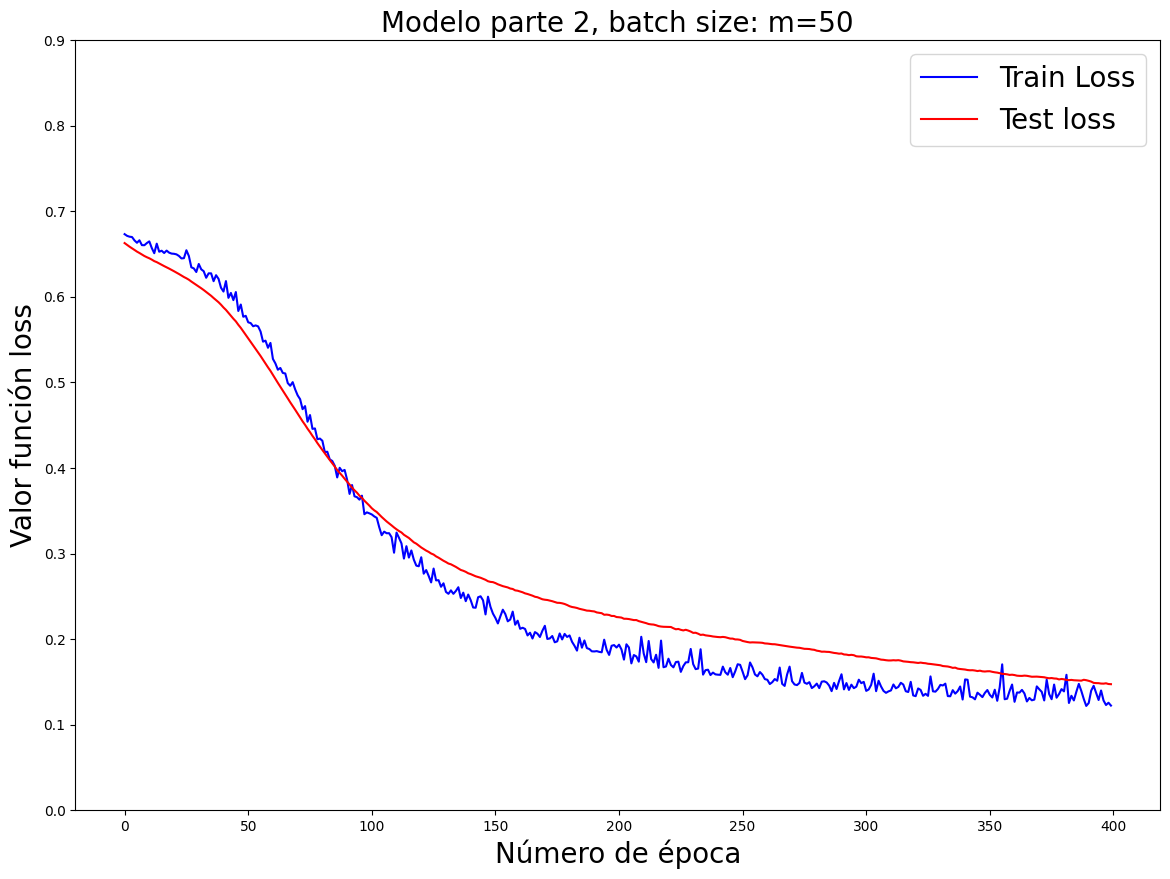

In [99]:
plot_epoch_vs_loss(data_list, "Modelo parte 2, batch size: m=50")

In [97]:
data_list = create_all(batch_size=len(train_data))

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.850 | Train Acc: 38.55%
	 Val. Loss: 0.847 |  Test. Acc: 38.46%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.846 | Train Acc: 38.55%
	 Val. Loss: 0.842 |  Test. Acc: 38.46%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.841 | Train Acc: 38.55%
	 Val. Loss: 0.838 |  Test. Acc: 38.46%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.837 | Train Acc: 38.55%
	 Val. Loss: 0.834 |  Test. Acc: 38.46%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.833 | Train Acc: 38.55%
	 Val. Loss: 0.830 |  Test. Acc: 38.46%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.829 | Train Acc: 38.55%
	 Val. Loss: 0.826 |  Test. Acc: 38.46%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.825 | Train Acc: 38.55%
	 Val. Loss: 0.823 |  Test. Acc: 38.46%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.821 | Train Acc: 38.55%
	 Val. Loss: 0.819 |  Test. Acc: 38.46%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.818 | Train Acc: 38.55%
	 Val. Loss: 0.815 |  Test. Acc: 38.46%
Epoch: 10 | Epoch T

Epoch: 77 | Epoch Time: 0m 0s
	Train Loss: 0.668 | Train Acc: 73.98%
	 Val. Loss: 0.670 |  Test. Acc: 69.23%
Epoch: 78 | Epoch Time: 0m 0s
	Train Loss: 0.667 | Train Acc: 75.18%
	 Val. Loss: 0.669 |  Test. Acc: 70.19%
Epoch: 79 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 75.66%
	 Val. Loss: 0.667 |  Test. Acc: 74.04%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 76.63%
	 Val. Loss: 0.666 |  Test. Acc: 75.00%
Epoch: 81 | Epoch Time: 0m 0s
	Train Loss: 0.663 | Train Acc: 78.07%
	 Val. Loss: 0.665 |  Test. Acc: 75.96%
Epoch: 82 | Epoch Time: 0m 0s
	Train Loss: 0.662 | Train Acc: 78.80%
	 Val. Loss: 0.663 |  Test. Acc: 76.92%
Epoch: 83 | Epoch Time: 0m 0s
	Train Loss: 0.660 | Train Acc: 80.96%
	 Val. Loss: 0.662 |  Test. Acc: 76.92%
Epoch: 84 | Epoch Time: 0m 0s
	Train Loss: 0.659 | Train Acc: 81.93%
	 Val. Loss: 0.661 |  Test. Acc: 78.85%
Epoch: 85 | Epoch Time: 0m 0s
	Train Loss: 0.658 | Train Acc: 82.65%
	 Val. Loss: 0.660 |  Test. Acc: 80.77%
Epoch: 86 | Epoch T

Epoch: 158 | Epoch Time: 0m 0s
	Train Loss: 0.590 | Train Acc: 61.45%
	 Val. Loss: 0.591 |  Test. Acc: 61.54%
Epoch: 159 | Epoch Time: 0m 0s
	Train Loss: 0.589 | Train Acc: 61.45%
	 Val. Loss: 0.590 |  Test. Acc: 61.54%
Epoch: 160 | Epoch Time: 0m 0s
	Train Loss: 0.589 | Train Acc: 61.45%
	 Val. Loss: 0.590 |  Test. Acc: 61.54%
Epoch: 161 | Epoch Time: 0m 0s
	Train Loss: 0.588 | Train Acc: 61.45%
	 Val. Loss: 0.589 |  Test. Acc: 61.54%
Epoch: 162 | Epoch Time: 0m 0s
	Train Loss: 0.587 | Train Acc: 61.45%
	 Val. Loss: 0.588 |  Test. Acc: 61.54%
Epoch: 163 | Epoch Time: 0m 0s
	Train Loss: 0.587 | Train Acc: 61.45%
	 Val. Loss: 0.588 |  Test. Acc: 61.54%
Epoch: 164 | Epoch Time: 0m 0s
	Train Loss: 0.586 | Train Acc: 61.45%
	 Val. Loss: 0.587 |  Test. Acc: 61.54%
Epoch: 165 | Epoch Time: 0m 0s
	Train Loss: 0.585 | Train Acc: 61.45%
	 Val. Loss: 0.586 |  Test. Acc: 61.54%
Epoch: 166 | Epoch Time: 0m 0s
	Train Loss: 0.585 | Train Acc: 61.45%
	 Val. Loss: 0.585 |  Test. Acc: 61.54%
Epoch: 167

Epoch: 248 | Epoch Time: 0m 0s
	Train Loss: 0.539 | Train Acc: 61.45%
	 Val. Loss: 0.538 |  Test. Acc: 61.54%
Epoch: 249 | Epoch Time: 0m 0s
	Train Loss: 0.539 | Train Acc: 61.45%
	 Val. Loss: 0.537 |  Test. Acc: 61.54%
Epoch: 250 | Epoch Time: 0m 0s
	Train Loss: 0.538 | Train Acc: 61.45%
	 Val. Loss: 0.537 |  Test. Acc: 61.54%
Epoch: 251 | Epoch Time: 0m 0s
	Train Loss: 0.538 | Train Acc: 61.45%
	 Val. Loss: 0.536 |  Test. Acc: 61.54%
Epoch: 252 | Epoch Time: 0m 0s
	Train Loss: 0.537 | Train Acc: 61.45%
	 Val. Loss: 0.536 |  Test. Acc: 61.54%
Epoch: 253 | Epoch Time: 0m 0s
	Train Loss: 0.537 | Train Acc: 61.45%
	 Val. Loss: 0.535 |  Test. Acc: 61.54%
Epoch: 254 | Epoch Time: 0m 0s
	Train Loss: 0.536 | Train Acc: 61.45%
	 Val. Loss: 0.534 |  Test. Acc: 61.54%
Epoch: 255 | Epoch Time: 0m 0s
	Train Loss: 0.536 | Train Acc: 61.45%
	 Val. Loss: 0.534 |  Test. Acc: 61.54%
Epoch: 256 | Epoch Time: 0m 0s
	Train Loss: 0.535 | Train Acc: 61.45%
	 Val. Loss: 0.533 |  Test. Acc: 61.54%
Epoch: 257

Epoch: 326 | Epoch Time: 0m 0s
	Train Loss: 0.499 | Train Acc: 63.37%
	 Val. Loss: 0.497 |  Test. Acc: 63.46%
Epoch: 327 | Epoch Time: 0m 0s
	Train Loss: 0.498 | Train Acc: 63.37%
	 Val. Loss: 0.496 |  Test. Acc: 63.46%
Epoch: 328 | Epoch Time: 0m 0s
	Train Loss: 0.498 | Train Acc: 63.37%
	 Val. Loss: 0.495 |  Test. Acc: 63.46%
Epoch: 329 | Epoch Time: 0m 0s
	Train Loss: 0.497 | Train Acc: 63.37%
	 Val. Loss: 0.495 |  Test. Acc: 63.46%
Epoch: 330 | Epoch Time: 0m 0s
	Train Loss: 0.497 | Train Acc: 63.37%
	 Val. Loss: 0.494 |  Test. Acc: 63.46%
Epoch: 331 | Epoch Time: 0m 0s
	Train Loss: 0.496 | Train Acc: 63.37%
	 Val. Loss: 0.494 |  Test. Acc: 63.46%
Epoch: 332 | Epoch Time: 0m 0s
	Train Loss: 0.496 | Train Acc: 63.37%
	 Val. Loss: 0.493 |  Test. Acc: 63.46%
Epoch: 333 | Epoch Time: 0m 0s
	Train Loss: 0.495 | Train Acc: 63.37%
	 Val. Loss: 0.493 |  Test. Acc: 63.46%
Epoch: 334 | Epoch Time: 0m 0s
	Train Loss: 0.495 | Train Acc: 63.37%
	 Val. Loss: 0.492 |  Test. Acc: 63.46%
Epoch: 335

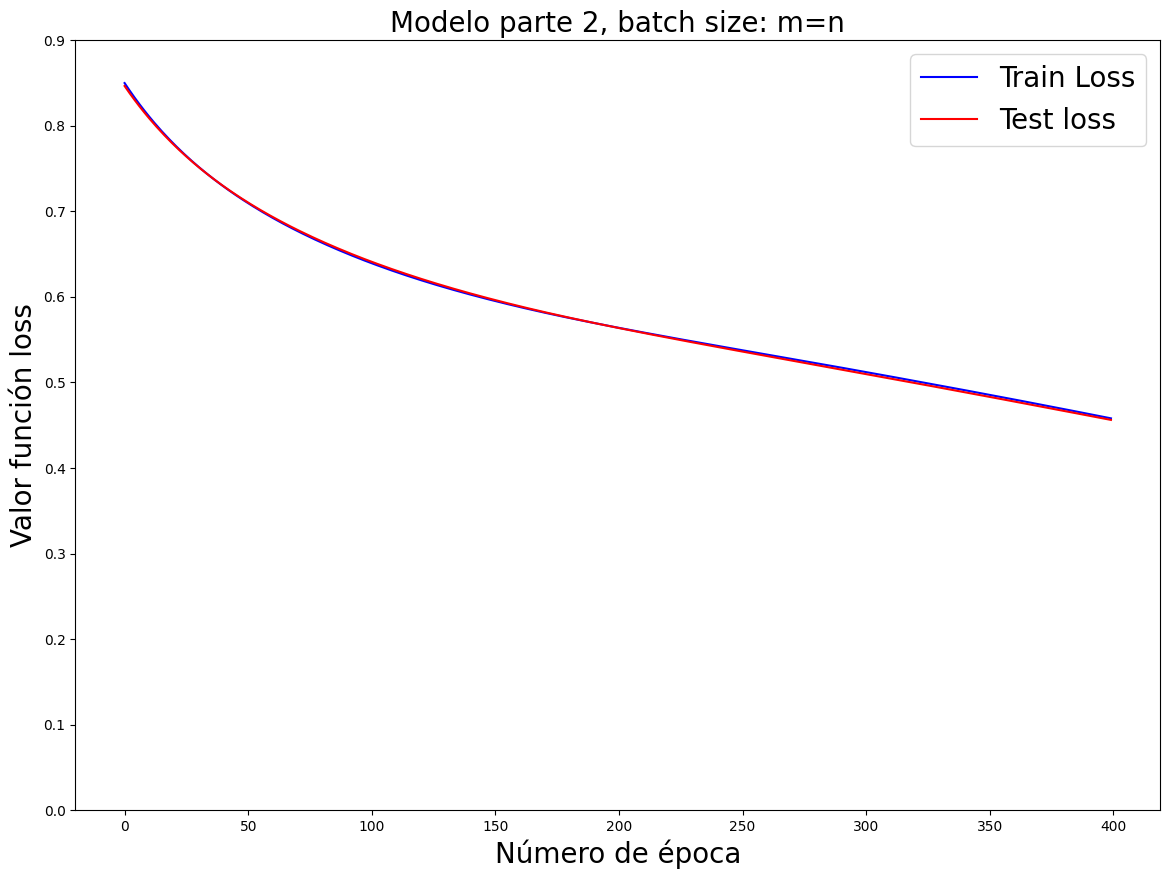

In [100]:
plot_epoch_vs_loss(data_list, "Modelo parte 2, batch size: m=n")

Para el primer caso, se tiene que batch_size$=1$, es decir, cada batch contiene solo un dato. En ese sentido, al momento de computar los gradientes y actualizar los parámetros, se utiliza solo la información de un dato para realizar dichas acciones. Así, la función de loss decrece con el tiempo pero oscila puesto que, como los gradientes dependen de un solo dato, la actualización de los parámetros es variable: un dato *difícil* de entrenar genera un gradiente *distinto* a el gradiente de un dato *fácil* de entrenar y, por ende, el valor de la función loss oscila. Sin embargo, como los datos siguen *cierta* distribución, los datos *fáciles de entrenar* permiten que, a grandes rasgos, la función loss decrezca con el tiempo (pero sin dejar de oscilar localmente).

Para el segundo caso, se tiene que batch_size$=50$, es decir, cada batch contiene 50 datos. En ese sentido, al momento de computar los gradientes y actualizar los parámetros, se utiliza la información de 50 datos para realizar dichas acciones. En comparación al primer caso, se tiene cierta oscilación pero es menor ya que, en este caso, el gradiente depende de 50 datos y no solo 1. Nótese que la oscilación es mayor en el dataset de entrenamiento que en el dataset de test. Lo anterior es debido al tamaño de los dataset: el dataset de entrenamiento es 4 veces el tamaño del dataset de test y, por tanto, su el valor de su función loss es más variable.

Finalmente, se tiene que batch_size$=n$, es decir, el batch contiene la totalidad de los datos de entrenamiento. Cuando se tiene que escoger un grandiente, se realiza *un promedio* con toda la data para establecer dicho gradiente. Nótese que la función loss decrece suavemente y sin oscilar y, por tanto, la actualización de los parámetro es más *suave*. Lo anteriormente mencionado tiene total coherencia con el hecho de que se utiliza un gradiente *promedio* de todos los datos puesto que, al ser un *promedio*, dicho gradiente genera una variación suave en los parámetros en cada actualización y, por tanto, el entrenamiento ocurre sin oscilación y de manera *lenta*.

# **Parte 3**
Intenta cambiar el learning rate. Como casos extremos usa lr = 0.5 y lr = 0.000001. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [101]:
data_list = create_all(learning_rate=0.5)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.577 | Train Acc: 67.38%
	 Val. Loss: 0.389 |  Test. Acc: 80.83%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.272 | Train Acc: 88.81%
	 Val. Loss: 0.188 |  Test. Acc: 91.67%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.214 | Train Acc: 92.62%
	 Val. Loss: 0.168 |  Test. Acc: 95.00%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.176 | Train Acc: 94.44%
	 Val. Loss: 0.199 |  Test. Acc: 90.83%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.182 | Train Acc: 93.73%
	 Val. Loss: 0.238 |  Test. Acc: 89.17%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.184 | Train Acc: 94.05%
	 Val. Loss: 0.242 |  Test. Acc: 92.50%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.165 | Train Acc: 94.76%
	 Val. Loss: 0.170 |  Test. Acc: 90.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.158 | Train Acc: 94.68%
	 Val. Loss: 0.157 |  Test. Acc: 95.00%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.143 | Train Acc: 95.71%
	 Val. Loss: 0.158 |  Test. Acc: 95.00%
Epoch: 10 | Epoch T

Epoch: 86 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.76%
	 Val. Loss: 0.066 |  Test. Acc: 97.50%
Epoch: 87 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.76%
	 Val. Loss: 0.063 |  Test. Acc: 97.50%
Epoch: 88 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.066 |  Test. Acc: 97.50%
Epoch: 89 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.064 |  Test. Acc: 97.50%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.061 |  Test. Acc: 97.50%
Epoch: 91 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.76%
	 Val. Loss: 0.062 |  Test. Acc: 97.50%
Epoch: 92 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.058 |  Test. Acc: 97.50%
Epoch: 93 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.52%
	 Val. Loss: 0.069 |  Test. Acc: 97.50%
Epoch: 94 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.76%
	 Val. Loss: 0.069 |  Test. Acc: 97.50%
Epoch: 95 | Epoch T

Epoch: 169 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.059 |  Test. Acc: 97.50%
Epoch: 170 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 171 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.054 |  Test. Acc: 97.50%
Epoch: 172 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.055 |  Test. Acc: 97.50%
Epoch: 173 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.054 |  Test. Acc: 97.50%
Epoch: 174 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.053 |  Test. Acc: 97.50%
Epoch: 175 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 176 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.057 |  Test. Acc: 97.50%
Epoch: 177 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.054 |  Test. Acc: 97.50%
Epoch: 178

Epoch: 256 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.057 |  Test. Acc: 97.50%
Epoch: 257 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.059 |  Test. Acc: 97.50%
Epoch: 258 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.68%
	 Val. Loss: 0.055 |  Test. Acc: 97.50%
Epoch: 259 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.055 |  Test. Acc: 97.50%
Epoch: 260 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 261 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 262 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 263 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.058 |  Test. Acc: 97.50%
Epoch: 264 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.057 |  Test. Acc: 97.50%
Epoch: 265

Epoch: 335 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 336 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.68%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 337 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 338 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.055 |  Test. Acc: 97.50%
Epoch: 339 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.060 |  Test. Acc: 97.50%
Epoch: 340 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.060 |  Test. Acc: 97.50%
Epoch: 341 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.061 |  Test. Acc: 97.50%
Epoch: 342 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.062 |  Test. Acc: 97.50%
Epoch: 343 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.060 |  Test. Acc: 97.50%
Epoch: 344

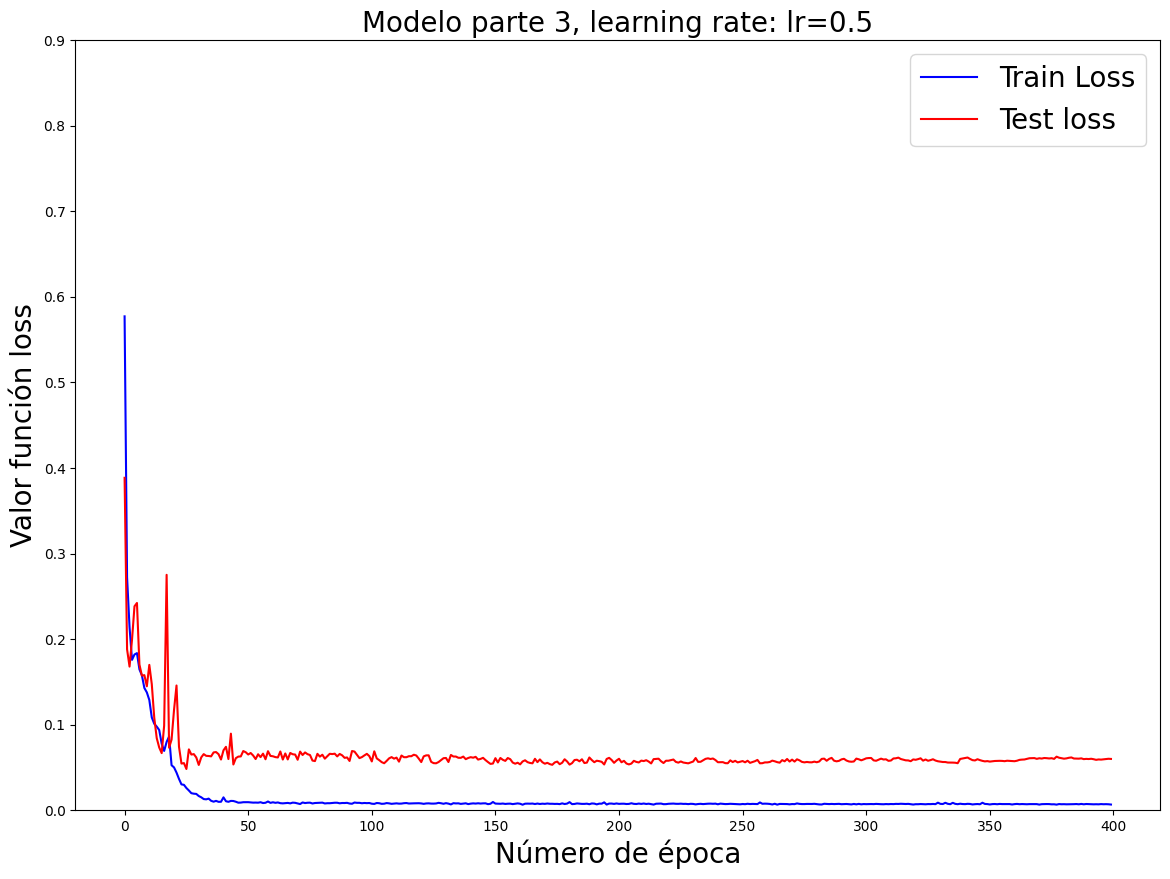

In [102]:
plot_epoch_vs_loss(data_list, "Modelo parte 3, learning rate: lr=0.5")

In [100]:
data_list = create_all(learning_rate=0.001)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.683 | Train Acc: 61.11%
	 Val. Loss: 0.679 |  Test. Acc: 63.33%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.682 | Train Acc: 61.35%
	 Val. Loss: 0.678 |  Test. Acc: 63.33%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.681 | Train Acc: 61.35%
	 Val. Loss: 0.677 |  Test. Acc: 63.33%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.680 | Train Acc: 61.03%
	 Val. Loss: 0.676 |  Test. Acc: 63.33%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.680 | Train Acc: 61.19%
	 Val. Loss: 0.675 |  Test. Acc: 63.33%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.679 | Train Acc: 61.51%
	 Val. Loss: 0.674 |  Test. Acc: 63.33%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.678 | Train Acc: 61.19%
	 Val. Loss: 0.674 |  Test. Acc: 63.33%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.677 | Train Acc: 61.67%
	 Val. Loss: 0.673 |  Test. Acc: 63.33%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.676 | Train Acc: 61.59%
	 Val. Loss: 0.672 |  Test. Acc: 63.33%
Epoch: 10 | Epoch T

Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.649 | Train Acc: 61.35%
	 Val. Loss: 0.642 |  Test. Acc: 63.33%
Epoch: 81 | Epoch Time: 0m 0s
	Train Loss: 0.648 | Train Acc: 61.35%
	 Val. Loss: 0.641 |  Test. Acc: 63.33%
Epoch: 82 | Epoch Time: 0m 0s
	Train Loss: 0.649 | Train Acc: 61.19%
	 Val. Loss: 0.641 |  Test. Acc: 63.33%
Epoch: 83 | Epoch Time: 0m 0s
	Train Loss: 0.648 | Train Acc: 61.27%
	 Val. Loss: 0.641 |  Test. Acc: 63.33%
Epoch: 84 | Epoch Time: 0m 0s
	Train Loss: 0.647 | Train Acc: 61.59%
	 Val. Loss: 0.641 |  Test. Acc: 63.33%
Epoch: 85 | Epoch Time: 0m 0s
	Train Loss: 0.648 | Train Acc: 61.27%
	 Val. Loss: 0.640 |  Test. Acc: 63.33%
Epoch: 86 | Epoch Time: 0m 0s
	Train Loss: 0.646 | Train Acc: 61.59%
	 Val. Loss: 0.640 |  Test. Acc: 63.33%
Epoch: 87 | Epoch Time: 0m 0s
	Train Loss: 0.646 | Train Acc: 61.51%
	 Val. Loss: 0.640 |  Test. Acc: 63.33%
Epoch: 88 | Epoch Time: 0m 0s
	Train Loss: 0.646 | Train Acc: 61.43%
	 Val. Loss: 0.639 |  Test. Acc: 63.33%
Epoch: 89 | Epoch T

Epoch: 156 | Epoch Time: 0m 0s
	Train Loss: 0.627 | Train Acc: 61.35%
	 Val. Loss: 0.621 |  Test. Acc: 63.33%
Epoch: 157 | Epoch Time: 0m 0s
	Train Loss: 0.626 | Train Acc: 61.51%
	 Val. Loss: 0.621 |  Test. Acc: 63.33%
Epoch: 158 | Epoch Time: 0m 0s
	Train Loss: 0.626 | Train Acc: 61.43%
	 Val. Loss: 0.620 |  Test. Acc: 63.33%
Epoch: 159 | Epoch Time: 0m 0s
	Train Loss: 0.626 | Train Acc: 61.43%
	 Val. Loss: 0.620 |  Test. Acc: 63.33%
Epoch: 160 | Epoch Time: 0m 0s
	Train Loss: 0.625 | Train Acc: 61.59%
	 Val. Loss: 0.620 |  Test. Acc: 63.33%
Epoch: 161 | Epoch Time: 0m 0s
	Train Loss: 0.624 | Train Acc: 61.75%
	 Val. Loss: 0.619 |  Test. Acc: 63.33%
Epoch: 162 | Epoch Time: 0m 0s
	Train Loss: 0.624 | Train Acc: 61.59%
	 Val. Loss: 0.619 |  Test. Acc: 63.33%
Epoch: 163 | Epoch Time: 0m 0s
	Train Loss: 0.624 | Train Acc: 61.51%
	 Val. Loss: 0.619 |  Test. Acc: 63.33%
Epoch: 164 | Epoch Time: 0m 0s
	Train Loss: 0.624 | Train Acc: 61.51%
	 Val. Loss: 0.619 |  Test. Acc: 63.33%
Epoch: 165

Epoch: 242 | Epoch Time: 0m 0s
	Train Loss: 0.590 | Train Acc: 64.13%
	 Val. Loss: 0.590 |  Test. Acc: 64.17%
Epoch: 243 | Epoch Time: 0m 0s
	Train Loss: 0.589 | Train Acc: 64.44%
	 Val. Loss: 0.589 |  Test. Acc: 64.17%
Epoch: 244 | Epoch Time: 0m 0s
	Train Loss: 0.590 | Train Acc: 64.05%
	 Val. Loss: 0.589 |  Test. Acc: 64.17%
Epoch: 245 | Epoch Time: 0m 0s
	Train Loss: 0.589 | Train Acc: 64.21%
	 Val. Loss: 0.589 |  Test. Acc: 64.17%
Epoch: 246 | Epoch Time: 0m 0s
	Train Loss: 0.588 | Train Acc: 64.13%
	 Val. Loss: 0.588 |  Test. Acc: 64.17%
Epoch: 247 | Epoch Time: 0m 0s
	Train Loss: 0.587 | Train Acc: 64.44%
	 Val. Loss: 0.588 |  Test. Acc: 64.17%
Epoch: 248 | Epoch Time: 0m 0s
	Train Loss: 0.587 | Train Acc: 64.44%
	 Val. Loss: 0.587 |  Test. Acc: 65.83%
Epoch: 249 | Epoch Time: 0m 0s
	Train Loss: 0.586 | Train Acc: 65.87%
	 Val. Loss: 0.587 |  Test. Acc: 69.17%
Epoch: 250 | Epoch Time: 0m 0s
	Train Loss: 0.586 | Train Acc: 65.71%
	 Val. Loss: 0.586 |  Test. Acc: 69.17%
Epoch: 251

Epoch: 325 | Epoch Time: 0m 0s
	Train Loss: 0.534 | Train Acc: 88.02%
	 Val. Loss: 0.544 |  Test. Acc: 83.33%
Epoch: 326 | Epoch Time: 0m 0s
	Train Loss: 0.534 | Train Acc: 87.70%
	 Val. Loss: 0.543 |  Test. Acc: 83.33%
Epoch: 327 | Epoch Time: 0m 0s
	Train Loss: 0.533 | Train Acc: 87.94%
	 Val. Loss: 0.543 |  Test. Acc: 83.33%
Epoch: 328 | Epoch Time: 0m 0s
	Train Loss: 0.531 | Train Acc: 88.10%
	 Val. Loss: 0.542 |  Test. Acc: 83.33%
Epoch: 329 | Epoch Time: 0m 0s
	Train Loss: 0.531 | Train Acc: 87.86%
	 Val. Loss: 0.541 |  Test. Acc: 83.33%
Epoch: 330 | Epoch Time: 0m 0s
	Train Loss: 0.531 | Train Acc: 87.94%
	 Val. Loss: 0.541 |  Test. Acc: 83.33%
Epoch: 331 | Epoch Time: 0m 0s
	Train Loss: 0.529 | Train Acc: 87.94%
	 Val. Loss: 0.540 |  Test. Acc: 83.33%
Epoch: 332 | Epoch Time: 0m 0s
	Train Loss: 0.529 | Train Acc: 87.94%
	 Val. Loss: 0.539 |  Test. Acc: 83.33%
Epoch: 333 | Epoch Time: 0m 0s
	Train Loss: 0.527 | Train Acc: 88.25%
	 Val. Loss: 0.539 |  Test. Acc: 83.33%
Epoch: 334

Epoch: 400 | Epoch Time: 0m 0s
	Train Loss: 0.467 | Train Acc: 89.84%
	 Val. Loss: 0.489 |  Test. Acc: 83.33%


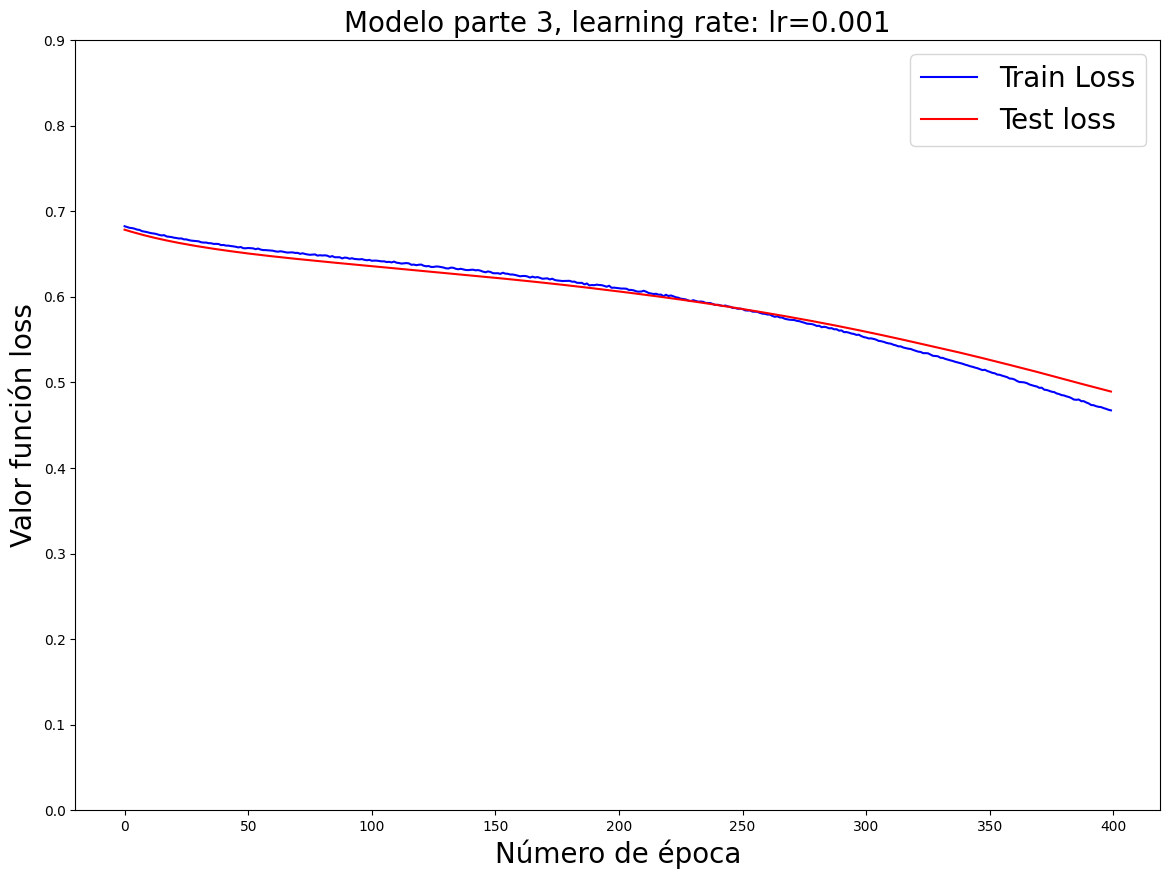

In [101]:
plot_epoch_vs_loss(data_list, "Modelo parte 3, learning rate: lr=0.001")

In [103]:
data_list = create_all(learning_rate=0.000001)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.89%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.65%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.49%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.49%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 10 | Epoch T

Epoch: 86 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 87 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 88 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 89 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 91 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 92 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 93 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.49%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 94 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.25%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 95 | Epoch T

Epoch: 163 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 164 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 165 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 166 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 167 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.49%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 168 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 169 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 170 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 171 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.49%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 172

Epoch: 249 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 250 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 251 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 252 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 253 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.49%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 254 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 255 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 256 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 257 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 258

Epoch: 334 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 335 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 336 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 337 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 338 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 339 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 340 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.81%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 341 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 342 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 343

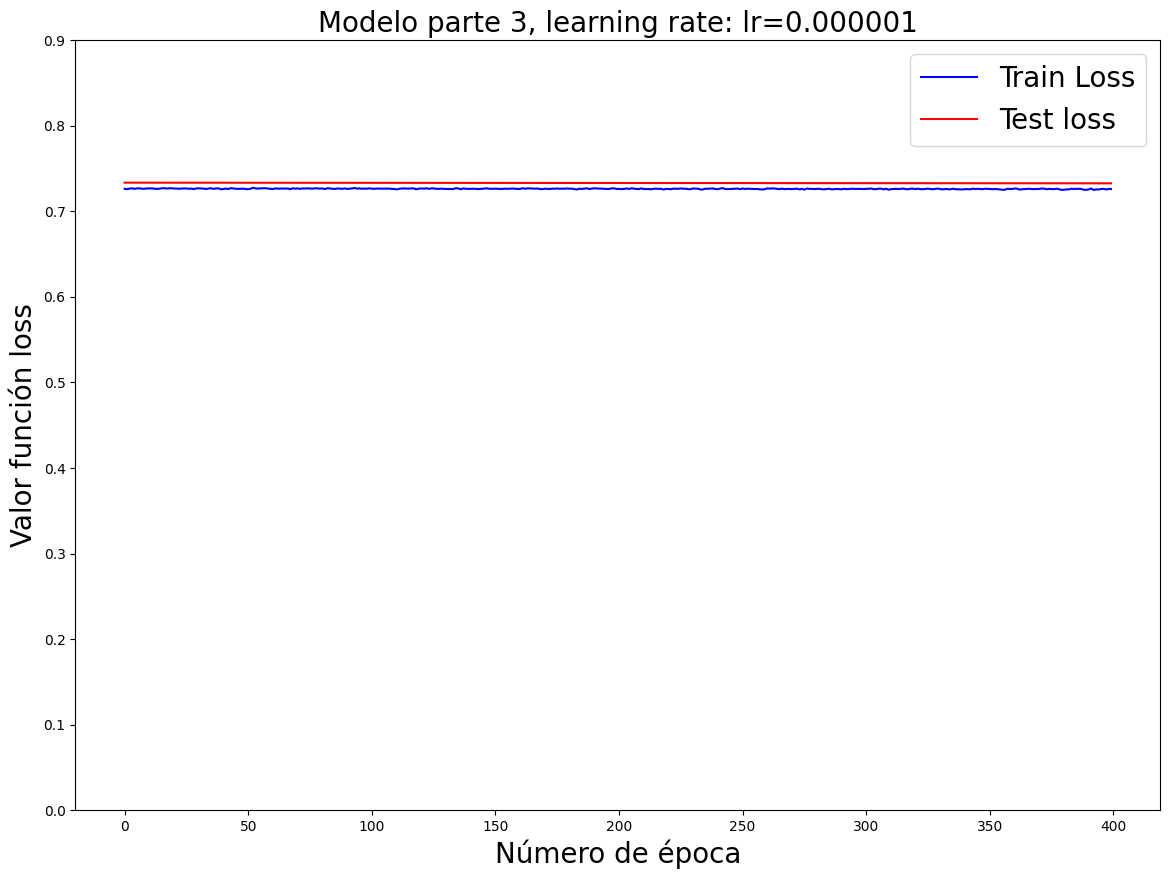

In [104]:
plot_epoch_vs_loss(data_list, "Modelo parte 3, learning rate: lr=0.000001")

Recordando lo visto es clases, la actualización de cada parámetro de la red viene dado por
\begin{equation}
v = v - n \cdot \nabla C 
\end{equation}
donde $v$ es el parámetro, $n$ es el learning rate $ \nabla C$ es el gradiente de la función loss.

En el primer caso, cuando se tiene que $lr=0.5$, el valor de la función loss para el dataset de test oscila mucho al principio pero luego se empieza a estabilizar (es decir, el valor de la función varía al principio pero luego empieza a converger). Lo anterior tiene sentido con el hecho de haber definido un learning rate *alto* ya que, al inicio, el valor de la función loss es más grande y, por ende, el valor del gradiente también y el un valor alto de learning rate conlleva a que la actualización de los parámetros sea *fuerte* (y por eso la oscilación). Luego, cuando el valor de la función loss empieza a disminuir (y, por tanto, también el gradiente), el valor alto de learning rate ya no conlleva tanto que la actualziación de los parámetros sea *fuerte* (y, por ende, la oscilación disminuye).

Por el otro lado, en el segundo caso, cuando se tiene que $lr=0.001$, el valor de la función loss varía poco (dado que el learning rate es pequeño). Que el valor de la funcion loss varíe poco significa que la red *aprende muy lento*. Así, se puede concluir que, dada la implemetación de la red, ocupar un learning rate pequeño conlleva a que la red aprenda *lento*.

En el último caso, cuando se tiene que $lr=0.00001$, el valor de la función loss varía muy poco (dado que el learning rate es muy pequeño). Que el valor de la funcion loss varíe poco significa que la red *aprende muy lento o casi no aprenda*. Así, se puede concluir que, dada la implemetación de la red, ocupar un learning rate muy pequeño conlleva a que la red aprenda *lento* o no aprenda nada. En este caso se tiene que:
\begin{equation}
v = v - n \cdot \nabla C 
\end{equation}

con $n \cdot \nabla C $ cercano a cero, es decir, se tiene que
\begin{equation}
v \approx v - 0
\end{equation}

\begin{equation}
v \approx v 
\end{equation}

Así, la actualización de parámetros ocurre de forma muy lenta, lo que conlleva a que la red aprenda lenta o definitivamente no aprenda.

En ese sentido, utilizar un learning rate muy alto supone una actualización *fuerte* de los parámetros que puede devenir en que el valor de la función loss varíe mucho y, en el otro extremo, utilizar un learning rate muy bajo supone que el modelo aprende muy poco o casi nada. Es por esto que, dependiendo de cada caso, se tiene que encontrar el learning rate más apto: uno que permite que el modelo *aprende* de forma rápida pero sin oscilaciones innecesarias.

# **Parte 4**
Implementar el algoritmo de gradiente descendente estocástico de manera que los mini-batches se generen de manera aleatoria antes de cada época. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [93]:
class RandomModel(Model):
    def __init__(self, optimizer, model, criterion, epoch, batch_size, X_train, Y_train, X_test, Y_test) -> None:
        super().__init__(optimizer, model, criterion, epoch, None, None)
        
        self.batch_size = batch_size
        self.total_train_iters = len(X_train)//batch_size + 1
        self.total_test_iters = len(X_test)//batch_size + 1
        
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        
    def train(self):
        epoch_loss = 0
        epoch_acc = 0

        #We have to set the neural network in training mode. This is because during
        #training, we need gradients and complementary data to ease the computation  
        self.model.train()
        
        for _ in range(self.total_train_iters):
            
            x = []
            y = []
            for _ in range(self.batch_size):
                i = random.randint(0, len(self.X_train)-1)
                x += [X_train[i]]
                y += [Y_train[i]]
            
            x = torch.stack(x)
            y = torch.stack(y)
            
            x = x.to(self.device) #Data
            y = y.to(self.device) #Labels
                
            self.optimizer.zero_grad() #Clean gradients
                     
            y_pred = self.model(x) #Feed the network with data

            loss = self.criterion(y_pred, y) #Compute the loss
               
            acc = self.calculate_accuracy(y_pred, y) #Compute the accuracy
                
            loss.backward() #Compute gradients
                
            self.optimizer.step() #Apply update rules
                
            epoch_loss += loss.item()
            epoch_acc += acc.item()
                
        return epoch_loss / self.total_train_iters, epoch_acc / self.total_train_iters

    def evaluate(self):
        epoch_loss = 0
        epoch_acc = 0
        
        # We put the network in testing mode
        #In this mode, Pytorch doesn't use features only reserved for 
        #training (dropout for instance)    
        self.model.eval()

        with torch.no_grad(): #disable the autograd engine (save computation and memory)
            for _ in range(self.total_test_iters):
                x = []
                y = []
                for _ in range(self.batch_size):
                    i = random.randint(0, len(self.X_test)-1)
                    x += [X_test[i]]
                    y += [Y_test[i]]
                
                x = torch.stack(x)
                y = torch.stack(y)
                
                x = x.to(self.device)
                y = y.to(self.device)

                y_pred = self.model(x)

                loss = self.criterion(y_pred, y)

                acc = self.calculate_accuracy(y_pred, y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

        return epoch_loss / self.total_test_iters, epoch_acc / self.total_test_iters

In [94]:
data_list = create_all(random=True)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.668 | Train Acc: 61.43%
	 Val. Loss: 0.671 |  Test. Acc: 60.00%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.660 | Train Acc: 63.10%
	 Val. Loss: 0.637 |  Test. Acc: 65.83%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.674 | Train Acc: 59.29%
	 Val. Loss: 0.649 |  Test. Acc: 64.17%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.669 | Train Acc: 60.71%
	 Val. Loss: 0.678 |  Test. Acc: 56.67%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.660 | Train Acc: 62.14%
	 Val. Loss: 0.657 |  Test. Acc: 61.67%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.654 | Train Acc: 63.33%
	 Val. Loss: 0.677 |  Test. Acc: 57.50%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.673 | Train Acc: 59.05%
	 Val. Loss: 0.681 |  Test. Acc: 56.67%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.672 | Train Acc: 58.81%
	 Val. Loss: 0.641 |  Test. Acc: 64.17%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.658 | Train Acc: 60.48%
	 Val. Loss: 0.659 |  Test. Acc: 60.00%
Epoch: 10 | Epoch T

Epoch: 78 | Epoch Time: 0m 0s
	Train Loss: 0.240 | Train Acc: 92.62%
	 Val. Loss: 0.235 |  Test. Acc: 95.00%
Epoch: 79 | Epoch Time: 0m 0s
	Train Loss: 0.240 | Train Acc: 91.90%
	 Val. Loss: 0.243 |  Test. Acc: 90.00%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.239 | Train Acc: 92.86%
	 Val. Loss: 0.257 |  Test. Acc: 90.83%
Epoch: 81 | Epoch Time: 0m 0s
	Train Loss: 0.274 | Train Acc: 91.19%
	 Val. Loss: 0.207 |  Test. Acc: 94.17%
Epoch: 82 | Epoch Time: 0m 0s
	Train Loss: 0.222 | Train Acc: 93.33%
	 Val. Loss: 0.191 |  Test. Acc: 95.00%
Epoch: 83 | Epoch Time: 0m 0s
	Train Loss: 0.244 | Train Acc: 92.62%
	 Val. Loss: 0.245 |  Test. Acc: 89.17%
Epoch: 84 | Epoch Time: 0m 0s
	Train Loss: 0.232 | Train Acc: 93.10%
	 Val. Loss: 0.223 |  Test. Acc: 90.83%
Epoch: 85 | Epoch Time: 0m 0s
	Train Loss: 0.238 | Train Acc: 93.33%
	 Val. Loss: 0.229 |  Test. Acc: 94.17%
Epoch: 86 | Epoch Time: 0m 0s
	Train Loss: 0.213 | Train Acc: 93.57%
	 Val. Loss: 0.257 |  Test. Acc: 87.50%
Epoch: 87 | Epoch T

Epoch: 155 | Epoch Time: 0m 0s
	Train Loss: 0.228 | Train Acc: 91.19%
	 Val. Loss: 0.265 |  Test. Acc: 88.33%
Epoch: 156 | Epoch Time: 0m 0s
	Train Loss: 0.138 | Train Acc: 96.43%
	 Val. Loss: 0.158 |  Test. Acc: 93.33%
Epoch: 157 | Epoch Time: 0m 0s
	Train Loss: 0.215 | Train Acc: 92.38%
	 Val. Loss: 0.193 |  Test. Acc: 93.33%
Epoch: 158 | Epoch Time: 0m 0s
	Train Loss: 0.159 | Train Acc: 94.05%
	 Val. Loss: 0.209 |  Test. Acc: 92.50%
Epoch: 159 | Epoch Time: 0m 0s
	Train Loss: 0.173 | Train Acc: 92.14%
	 Val. Loss: 0.230 |  Test. Acc: 89.17%
Epoch: 160 | Epoch Time: 0m 0s
	Train Loss: 0.131 | Train Acc: 95.95%
	 Val. Loss: 0.144 |  Test. Acc: 93.33%
Epoch: 161 | Epoch Time: 0m 0s
	Train Loss: 0.143 | Train Acc: 95.24%
	 Val. Loss: 0.270 |  Test. Acc: 88.33%
Epoch: 162 | Epoch Time: 0m 0s
	Train Loss: 0.155 | Train Acc: 94.52%
	 Val. Loss: 0.188 |  Test. Acc: 94.17%
Epoch: 163 | Epoch Time: 0m 0s
	Train Loss: 0.171 | Train Acc: 95.00%
	 Val. Loss: 0.235 |  Test. Acc: 90.00%
Epoch: 164

Epoch: 239 | Epoch Time: 0m 0s
	Train Loss: 0.142 | Train Acc: 95.48%
	 Val. Loss: 0.224 |  Test. Acc: 90.83%
Epoch: 240 | Epoch Time: 0m 0s
	Train Loss: 0.128 | Train Acc: 96.19%
	 Val. Loss: 0.236 |  Test. Acc: 88.33%
Epoch: 241 | Epoch Time: 0m 0s
	Train Loss: 0.127 | Train Acc: 96.19%
	 Val. Loss: 0.118 |  Test. Acc: 97.50%
Epoch: 242 | Epoch Time: 0m 0s
	Train Loss: 0.141 | Train Acc: 95.95%
	 Val. Loss: 0.245 |  Test. Acc: 90.00%
Epoch: 243 | Epoch Time: 0m 0s
	Train Loss: 0.124 | Train Acc: 95.71%
	 Val. Loss: 0.224 |  Test. Acc: 91.67%
Epoch: 244 | Epoch Time: 0m 0s
	Train Loss: 0.135 | Train Acc: 95.48%
	 Val. Loss: 0.288 |  Test. Acc: 87.50%
Epoch: 245 | Epoch Time: 0m 0s
	Train Loss: 0.158 | Train Acc: 95.24%
	 Val. Loss: 0.198 |  Test. Acc: 94.17%
Epoch: 246 | Epoch Time: 0m 0s
	Train Loss: 0.159 | Train Acc: 93.81%
	 Val. Loss: 0.183 |  Test. Acc: 95.00%
Epoch: 247 | Epoch Time: 0m 0s
	Train Loss: 0.160 | Train Acc: 95.24%
	 Val. Loss: 0.118 |  Test. Acc: 95.83%
Epoch: 248

Epoch: 315 | Epoch Time: 0m 0s
	Train Loss: 0.149 | Train Acc: 95.71%
	 Val. Loss: 0.181 |  Test. Acc: 91.67%
Epoch: 316 | Epoch Time: 0m 0s
	Train Loss: 0.106 | Train Acc: 96.90%
	 Val. Loss: 0.158 |  Test. Acc: 95.00%
Epoch: 317 | Epoch Time: 0m 0s
	Train Loss: 0.126 | Train Acc: 96.90%
	 Val. Loss: 0.205 |  Test. Acc: 92.50%
Epoch: 318 | Epoch Time: 0m 0s
	Train Loss: 0.108 | Train Acc: 97.38%
	 Val. Loss: 0.171 |  Test. Acc: 95.00%
Epoch: 319 | Epoch Time: 0m 0s
	Train Loss: 0.104 | Train Acc: 97.86%
	 Val. Loss: 0.212 |  Test. Acc: 93.33%
Epoch: 320 | Epoch Time: 0m 0s
	Train Loss: 0.139 | Train Acc: 95.00%
	 Val. Loss: 0.242 |  Test. Acc: 91.67%
Epoch: 321 | Epoch Time: 0m 0s
	Train Loss: 0.129 | Train Acc: 96.67%
	 Val. Loss: 0.124 |  Test. Acc: 95.83%
Epoch: 322 | Epoch Time: 0m 0s
	Train Loss: 0.144 | Train Acc: 95.48%
	 Val. Loss: 0.139 |  Test. Acc: 95.00%
Epoch: 323 | Epoch Time: 0m 0s
	Train Loss: 0.140 | Train Acc: 96.43%
	 Val. Loss: 0.081 |  Test. Acc: 98.33%
Epoch: 324

Epoch: 398 | Epoch Time: 0m 0s
	Train Loss: 0.095 | Train Acc: 97.86%
	 Val. Loss: 0.093 |  Test. Acc: 95.83%
Epoch: 399 | Epoch Time: 0m 0s
	Train Loss: 0.101 | Train Acc: 97.14%
	 Val. Loss: 0.187 |  Test. Acc: 91.67%
Epoch: 400 | Epoch Time: 0m 0s
	Train Loss: 0.133 | Train Acc: 95.24%
	 Val. Loss: 0.127 |  Test. Acc: 96.67%


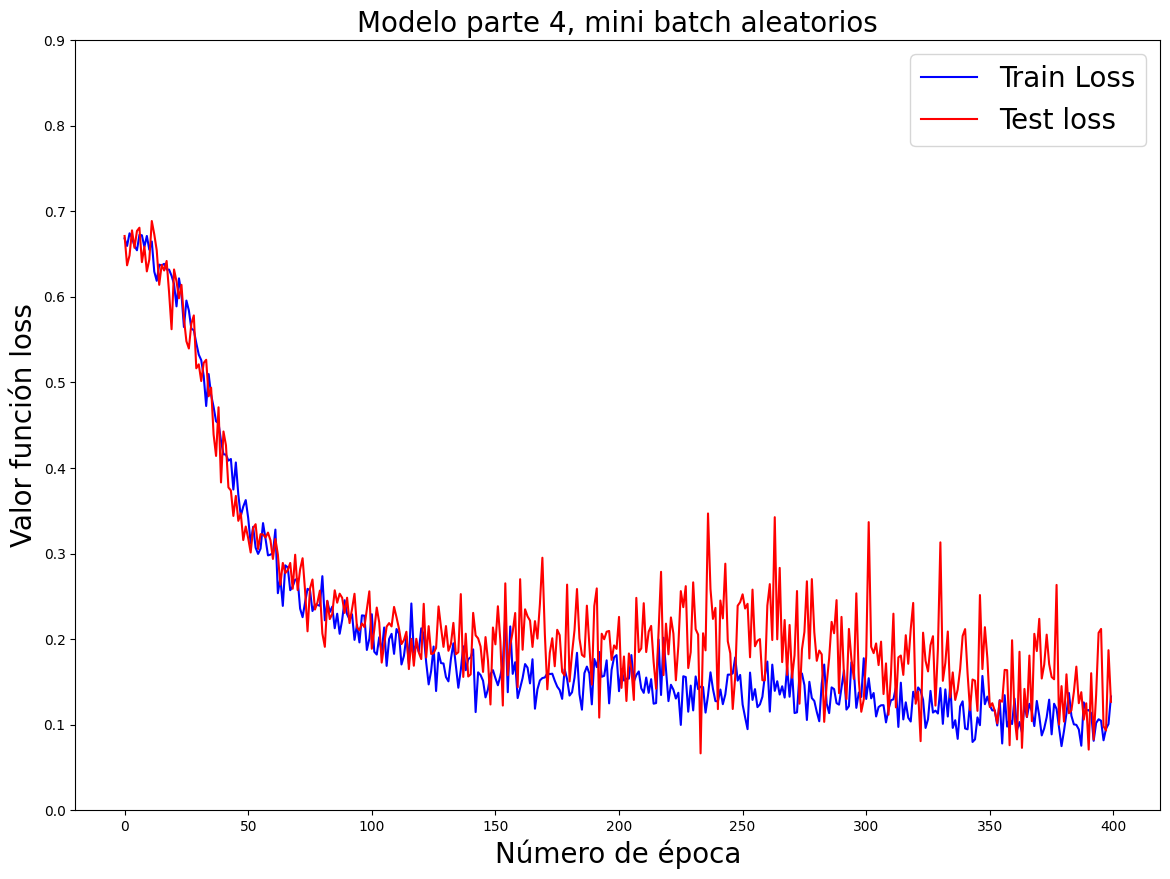

In [95]:
plot_epoch_vs_loss(data_list, "Modelo parte 4, mini batch aleatorios")

Dado que los mini batches se generan de manera aleatoria en cada época, los gradientes asociados a cada actualización son aleatorios en el sentido de que se utilizó un conjunto aleatorios de datos para generar dicho gradiente y la correspondiente actualización de parámetros. Por tanto, la actualización de los parámetro sigue cierta aleatoreidad que se observa en la oscilación de los valores de la función loss. Sin embargo, a pesar de que los parámetros actualizados siguen cierta aleatoreidad, los datos en su totalidad siguen una distribución y, por tanto, a pesar de la aleatoreidad observada en la oscilación de la función, a lo largo del *tiempo*, el valor promedio de la función loss va disminuyendo puesto que, a pesar de la aleatoreidad, el modelo se acerca de forma *oscilante* a los parámetros óptimos.